# Task A: Download Source Data

In [1]:
import requests
from tqdm.auto import tqdm
import os
import zipfile

Download .zip file from https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip

In [2]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip"

if not os.path.exists(os.path.basename(dataset_url)):
    response = requests.get(dataset_url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(os.path.basename(dataset_url), 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        raise Exception("ERROR, something went wrong")

Unzip data into `wisdm-dataset/` folder

In [3]:
if not ( os.path.exists('wisdm-dataset') and os.path.isdir('wisdm-dataset') ):
    zipfile.ZipFile("wisdm-dataset.zip").extractall()

# Task B: Process Raw Data

In [4]:
import pandas as pd
import numpy as np
import glob
import tqdm.auto
import os
import re
import warnings

import dask.distributed

#### Parameters

In [5]:
WINDOW_DURATION_SECONDS = 15

#### Start a Dask client

In [6]:
client = dask.distributed.Client()

client

Client Scheduler: tcp://127.0.0.1:56789 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.00 GiB


#### Generate Windowed Raw Data

In [7]:
def process_subject_raw_data_files(subject_id):
    activity_map = pd.read_table(
        'wisdm-dataset/activity_key.txt',
        sep = ' = ',
        header = None,
        engine = 'python',
        names = ['activity_name', 'activity_id']
    ).set_index('activity_id')['activity_name'].to_dict()
    
    def process_raw_data_file(sensor, device):
        df = pd.read_table(
            f'wisdm-dataset/raw/{device}/{sensor}/data_{subject_id}_{sensor}_{device}.txt',
            sep = ',',
            header = None, 
            names = ['subject_id', 'activity_id', 'timestamp', 'x', 'y', 'z'],
        )

        # The end of each line has a semi-colon which is being stored in the "z" column; remove this semi-colon.
        df['z'] = df['z'].str[0:-1].astype(float)

        # Rename x, y, z columns
        df.rename(columns={'x': f'{sensor}_{device}_x', 'y': f'{sensor}_{device}_y', 'z': f'{sensor}_{device}_z'}, inplace=True)

        # Map activity_id to activity name
        df['activity_name'] = df['activity_id'].map(activity_map)

        # Calculate t0 (unique for each subject, device, sensor, and activity)
        df = df.merge(df.groupby(['activity_id'])['timestamp'].min().reset_index().rename(columns={'timestamp': 't0'}))

        # Calculate t (from t0) (Units = milliseconds)
        df['t_ms'] = ( df['timestamp'] - df['t0'] ) / 1_000_000

        # Round t_ms rounded to nearest 50 ms (because sensor sampling rate = 20Hz)
        base = 50
        df['t_ms_rounded'] = df['t_ms'].apply(lambda x: base * round(float(x) / base)).astype('int')

        # Compute absolute delta between t_ms and t_ms_rounded
        df['abs_delta_ms'] = ( df['t_ms'] - df['t_ms_rounded'] ).abs()

        # Sort by time
        df.sort_values(['activity_id', 't_ms', 'abs_delta_ms'], ascending=[True, True, False], inplace=True)

        # Remove duplicates (for each activity, by t_ms_rounded)
        df.drop_duplicates(subset=['activity_id', 't_ms_rounded'], keep='first', inplace=True)

        # Calculate segment sequence number
        df['segment_sequence_number'] = np.floor(df['t_ms'] / 1_000 / WINDOW_DURATION_SECONDS).astype(int) + 1

        # Remove irrelevant columns
        df.drop(columns=['timestamp', 't0', 't_ms', 'abs_delta_ms'], inplace=True)

        activity_dfs = []
        # Add dataframe to subject_dfs
        for activity_id in df['activity_id'].unique():
            activity_df = df[df['activity_id'] == activity_id].copy()
            assert activity_df['t_ms_rounded'].is_monotonic_increasing
            activity_df.set_index(['subject_id', 'activity_id', 'activity_name', 'segment_sequence_number', 't_ms_rounded'], inplace=True)
            activity_dfs.append(activity_df)

        return pd.concat(activity_dfs, axis=0)
    
    subject_dfs = []
    for sensor in ('accel', 'gyro'):
        for device in ('phone', 'watch'):
            subject_dfs.append(process_raw_data_file(sensor, device))
            
    # In subject_dfs,
    #   - The 1st dataframe is accel_phone
    #   - The 2nd dataframe is accel_watch
    #   - The 3rd dataframe is gyro_phone
    #   - The 4th dataframe is gyro_watch
    return pd.concat(subject_dfs, axis=1)

In [8]:
subject_ids = pd.Series(
    glob.glob('wisdm-dataset/raw/*/*/*.txt', recursive=True)
).str.extract(r'^.+data_(\d+?)_.+$', expand=False).astype('int').sort_values().unique()

subject_data_futures = []
for subject_id in subject_ids:
    subject_data_futures.append(client.submit(process_subject_raw_data_files, subject_id))

print('Waiting for all Jobs to Complete...', end='')
df = pd.concat(client.gather(subject_data_futures), axis=0)
print('done!' + '\n')

df.info()

Waiting for all Jobs to Complete...done!

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3298350 entries, (1600, 'A', 'walking', 1, 0) to (1650, 'S', 'folding', 12, 180000)
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   accel_phone_x  float64
 1   accel_phone_y  float64
 2   accel_phone_z  float64
 3   accel_watch_x  float64
 4   accel_watch_y  float64
 5   accel_watch_z  float64
 6   gyro_phone_x   float64
 7   gyro_phone_y   float64
 8   gyro_phone_z   float64
 9   gyro_watch_x   float64
 10  gyro_watch_y   float64
 11  gyro_watch_z   float64
dtypes: float64(12)
memory usage: 321.0+ MB


In [9]:
# Add unique segment IDs to each time segment
segment_ids = pd.Series(index=df.index.droplevel(4).drop_duplicates(), data=np.arange(len(df.index.droplevel(4).drop_duplicates()))+1)
segment_ids.name = 'segment_id'

df = pd.merge(
    left = df,
    right = segment_ids,
    how = 'left',
    left_index = True,
    right_index = True,
)

df.set_index('segment_id', append=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3298350 entries, (1600, 'A', 'walking', 1, 0, 1) to (1650, 'S', 'folding', 12, 180000, 11138)
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   accel_phone_x  float64
 1   accel_phone_y  float64
 2   accel_phone_z  float64
 3   accel_watch_x  float64
 4   accel_watch_y  float64
 5   accel_watch_z  float64
 6   gyro_phone_x   float64
 7   gyro_phone_y   float64
 8   gyro_phone_z   float64
 9   gyro_watch_x   float64
 10  gyro_watch_y   float64
 11  gyro_watch_z   float64
dtypes: float64(12)
memory usage: 327.6+ MB


#### Write `df` to disk

In [10]:
df.to_parquet('processed_raw_data.parquet', index=True)

# Task C: Feature Extraction

In [11]:
import pandas as pd
import numpy as np
import tsfresh

#### Load raw data from `processed_raw_data.parquet`

This data was generated in **Task B**.

Note: This stage takes about 1 hour to run. The output file was written to S3 and is available publicly from there, if you wish to skip this step.

In [12]:
if not os.path.exists('tsfresh_relevant_features.parquet'):
    # Load raw data frame
    processed_raw_data_df = pd.read_parquet('processed_raw_data.parquet')

    # Put `t_ms_rounded` and `segment_id` back in dataframe
    df = processed_raw_data_df.reset_index(['t_ms_rounded', 'segment_id'])

    # Drop any rows with NaNs (only about 3%)
    df.dropna(how='any', inplace=True)

    # Load labels for each segment
    y = processed_raw_data_df\
        .reset_index()\
        .dropna(how='any')\
        .filter(items=['segment_id', 'activity_name'])\
        .drop_duplicates()\
        .set_index('segment_id')['activity_name']

    # Extract relevant features using `tsfresh`
    relevant_features_df = tsfresh.extract_relevant_features(
        timeseries_container = df,
        y = y,
        column_id = 'segment_id',
        column_sort = 't_ms_rounded',
    )

    # Write to disk
    relevant_features_df.to_parquet('tsfresh_relevant_features.parquet', index=True)

    relevant_features_df.info()

# Task D: Model Development

In [13]:
import os
import requests
import tqdm.auto
import pandas as pd
import numpy as np
import joblib

import dask_ml.preprocessing
import dask.distributed

import sklearn.model_selection
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#### Download features data from s3 (if necessary)

In [14]:
dataset_url = "https://mustafa-burny-dse230-20210523.s3-us-west-2.amazonaws.com/final-project/tsfresh_relevant_features.parquet"

if not os.path.exists(os.path.basename(dataset_url)):
    response = requests.get(dataset_url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm.auto.tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(os.path.basename(dataset_url), 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        raise Exception("ERROR, something went wrong")

#### Load features and labels data (from local disk)

In [15]:
# Read features data
features_df = pd.read_parquet('tsfresh_relevant_features.parquet')

# Extract label data from processed raw data
segment_labels = pd.read_parquet('processed_raw_data.parquet').reset_index()\
    .filter(items=['segment_id', 'activity_name'])\
    .drop_duplicates()\
    .set_index('segment_id')['activity_name']

# Combine features and segment lables into a single dataframe
df = pd.merge(
    left = features_df,
    right = segment_labels,
    how = 'left',
    left_index = True,
    right_index = True
)

# Convert activity name to an ordered Categorical
df['activity_name'] = pd.Categorical(
    df['activity_name'],
    categories = pd.read_parquet('processed_raw_data.parquet').reset_index()\
        .filter(items=['activity_id', 'activity_name'])\
        .drop_duplicates()\
        .sort_values('activity_id')['activity_name'].values,
    ordered = True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10809 entries, 1 to 11138
Columns: 5146 entries, accel_phone_y__variance_larger_than_standard_deviation to activity_name
dtypes: category(1), float64(5145)
memory usage: 424.6 MB


### Process into training and testing data

In [16]:
# Some Parameters
SEED = 42
TRAIN_SIZE = 0.25
TEST_SIZE = 0.75

# Get features and labels
X = df.iloc[:, 0:-1].copy()
y = df.iloc[:, -1].copy()

# Encode target labels as numbers
label_encoder = dask_ml.preprocessing.LabelEncoder(use_categorical=True)
label_encoder.fit(y)
y = label_encoder.transform(y)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = dask_ml.model_selection.train_test_split(
    X, y, 
    train_size = TRAIN_SIZE, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

# Scale features (using training data only)
standard_scaler = dask_ml.preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train).values
X_test = standard_scaler.transform(X_test).values

#### Linear Support Vector Classification (SVC)

In [17]:
param_grid = {
    'C': np.logspace(-3, 2, 25),
}

search = sklearn.model_selection.GridSearchCV(
    sklearn.svm.SVC(gamma='auto', random_state=SEED, kernel='linear', probability=True),
    param_grid = param_grid,
    return_train_score = False,
    cv = 3,
    verbose = True
)

with joblib.parallel_backend('dask'):
    # We perform the hyperparameter search using a smaller dataset
    X_train_HP, _, y_train_HP, _ = dask_ml.model_selection.train_test_split(X_train, y_train, train_size=1000, test_size=1, random_state=SEED)
    search.fit(X_train_HP, y_train_HP)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [18]:
model = search.best_estimator_.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('       Best Model: {}'.format(search.best_estimator_))
print('  Best Parameters: {}'.format(search.best_params_))
print('Training Accuracy: {:.2%}'.format(model.score(X_train, y_train)))
print(' Testing Accuracy: {:.2%}'.format(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)))

       Best Model: SVC(C=0.0016155980984398745, gamma='auto', kernel='linear', probability=True,
    random_state=42)
  Best Parameters: {'C': 0.0016155980984398745}
Training Accuracy: 99.67%
 Testing Accuracy: 85.41%


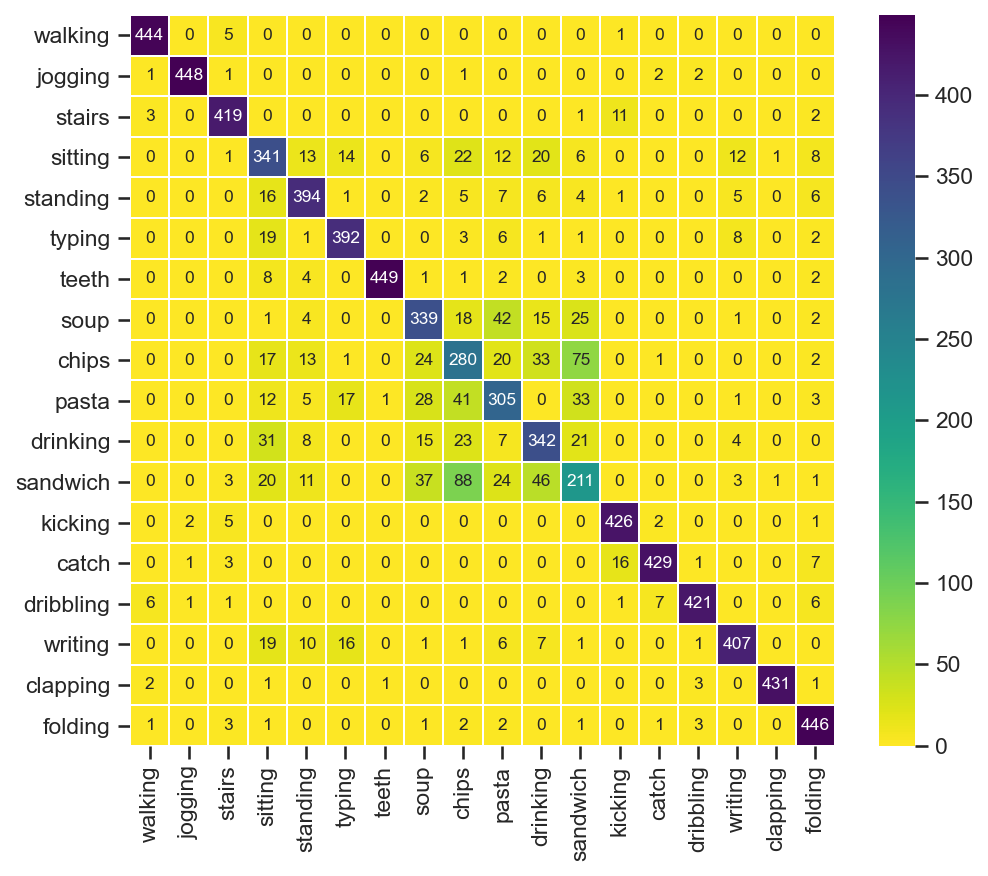

In [19]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
sns.despine()

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(
    pd.DataFrame(
        confusion_matrix, 
        index = label_encoder.classes_, 
        columns = label_encoder.classes_
    ),
    cbar = True,
    annot = True,
    fmt = 'd',
    annot_kws = {"fontsize": 'x-small'},
    linewidths = 0.1,
    cmap = 'viridis_r',
)

fig.tight_layout()
plt.close('all')

fig

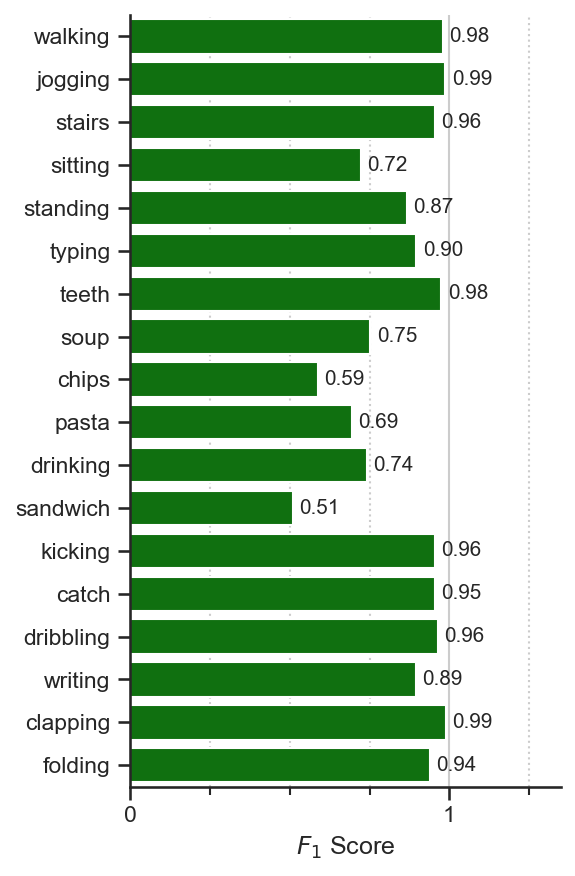

In [20]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=150)
sns.despine()

graph_data = pd.DataFrame(sklearn.metrics.classification_report(
    y_test,
    y_pred,
    target_names = label_encoder.classes_,
    output_dict = True
)).T['f1-score'].iloc[0:-3]

sns.barplot(
    x = graph_data.values,
    y = graph_data.index.values,
    color = 'green'
)

for i, (label, value) in enumerate(graph_data.iteritems()):
    ax.text(value + 0.02, i, '{:.2f}'.format(value), ha='left', va='center', fontsize='small')

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.25))
ax.grid(True, which='major', axis='x', color='#cccccc', linestyle='solid')
ax.grid(True, which='minor', axis='x', color='#cccccc', linestyle='dotted')
ax.set_xlim(left=0, right=1.35)
ax.set_xlabel('$F_1$ Score')

fig.tight_layout()
plt.close('all')

fig

#### Random Forest Classifier

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2],
}

search = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(random_state=SEED),
    param_grid = param_grid,
    return_train_score = False,
    cv = 3,
    verbose = True
)

with joblib.parallel_backend('dask'):
    # We perform the hyperparameter search using a smaller dataset
    X_train_HP, _, y_train_HP, _ = dask_ml.model_selection.train_test_split(X_train, y_train, train_size=1000, test_size=1, random_state=SEED)
    search.fit(X_train_HP, y_train_HP)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [22]:
model = search.best_estimator_.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('       Best Model: {}'.format(search.best_estimator_))
print('  Best Parameters: {}'.format(search.best_params_))
print('Training Accuracy: {:.2%}'.format(model.score(X_train, y_train)))
print(' Testing Accuracy: {:.2%}'.format(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)))

       Best Model: RandomForestClassifier(n_estimators=300, random_state=42)
  Best Parameters: {'max_depth': None, 'n_estimators': 300}
Training Accuracy: 100.00%
 Testing Accuracy: 86.81%


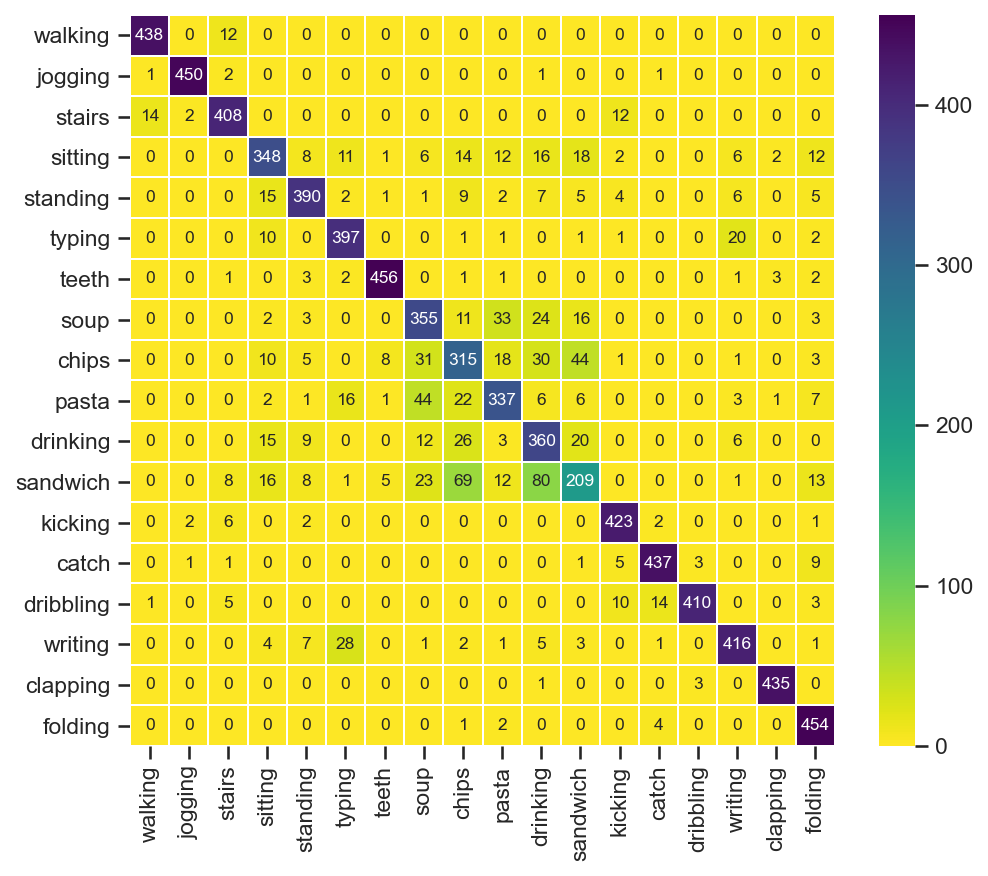

In [23]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
sns.despine()

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(
    pd.DataFrame(
        confusion_matrix, 
        index = label_encoder.classes_, 
        columns = label_encoder.classes_
    ),
    cbar = True,
    annot = True,
    fmt = 'd',
    annot_kws = {"fontsize": 'x-small'},
    linewidths = 0.1,
    cmap = 'viridis_r',
)

fig.tight_layout()
plt.close('all')

fig

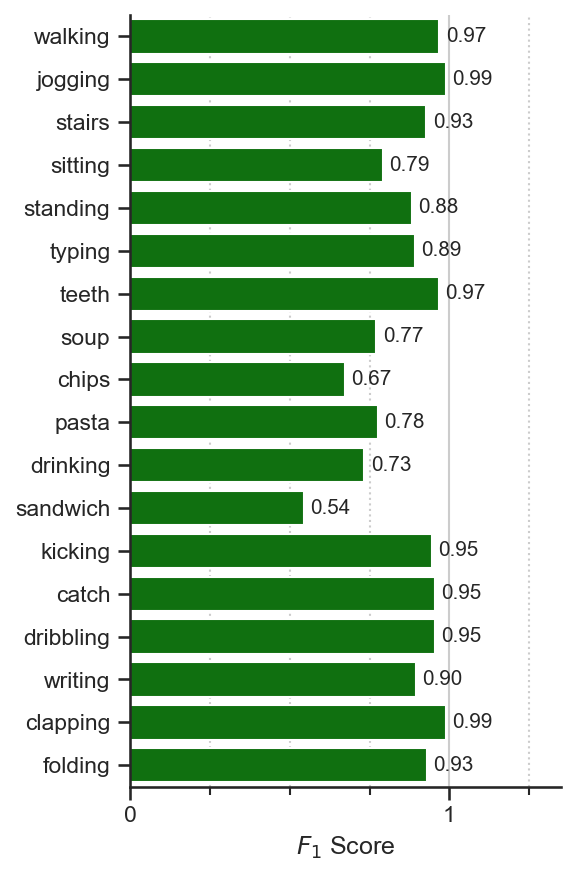

In [24]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=150)
sns.despine()

graph_data = pd.DataFrame(sklearn.metrics.classification_report(
    y_test,
    y_pred,
    target_names = label_encoder.classes_,
    output_dict = True
)).T['f1-score'].iloc[0:-3]

sns.barplot(
    x = graph_data.values,
    y = graph_data.index.values,
    color = 'green'
)

for i, (label, value) in enumerate(graph_data.iteritems()):
    ax.text(value + 0.02, i, '{:.2f}'.format(value), ha='left', va='center', fontsize='small')

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.25))
ax.grid(True, which='major', axis='x', color='#cccccc', linestyle='solid')
ax.grid(True, which='minor', axis='x', color='#cccccc', linestyle='dotted')
ax.set_xlim(left=0, right=1.35)
ax.set_xlabel('$F_1$ Score')

fig.tight_layout()
plt.close('all')

fig

#### Shutdown Dask client

In [25]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
